# MLP, QRNN, CNN, LSTM

# MLP

In [6]:
import numpy as np
import pandas as pd

df = pd.read_csv("Delhi Air Quality Data.csv",usecols=['Datetime','AQI'],parse_dates=['Datetime'])
df.set_index('Datetime',inplace=True)

In [7]:
df.head(20)

,AQI
Datetime,
2015-01-01 01:00:00,NaN
2015-01-01 02:00:00,NaN
2015-01-01 03:00:00,NaN
2015-01-01 04:00:00,NaN
2015-01-01 05:00:00,NaN
2015-01-01 06:00:00,NaN
2015-01-01 07:00:00,NaN
2015-01-01 08:00:00,NaN
2015-01-01 09:00:00,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48192 entries, 2015-01-01 01:00:00 to 2020-01-07 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AQI     47694 non-null  float64
dtypes: float64(1)
memory usage: 753.0 KB


### Since first few points are missing, I am deleting the first few rows and using interpolation on the rest of the dataset to fill in the missing values.

In [14]:
df = df.iloc[15:,:]
df.head(10)

,AQI
Datetime,
2015-01-01 16:00:00,456.0
2015-01-01 17:00:00,450.0
2015-01-01 18:00:00,446.0
2015-01-01 19:00:00,475.0
2015-01-01 20:00:00,480.0
2015-01-01 21:00:00,484.0
2015-01-01 22:00:00,488.0
2015-01-01 23:00:00,494.0
2015-02-01 00:00:00,501.0


In [22]:
df[['AQI']].interpolate(method='polynomial',order=3,inplace=True)

### Visualize Time Series Data

Text(0.5, 1.0, 'Delhi Hourly AQI from 2015-01-01 16:00:00 to 2020-12-06 23:00:00')

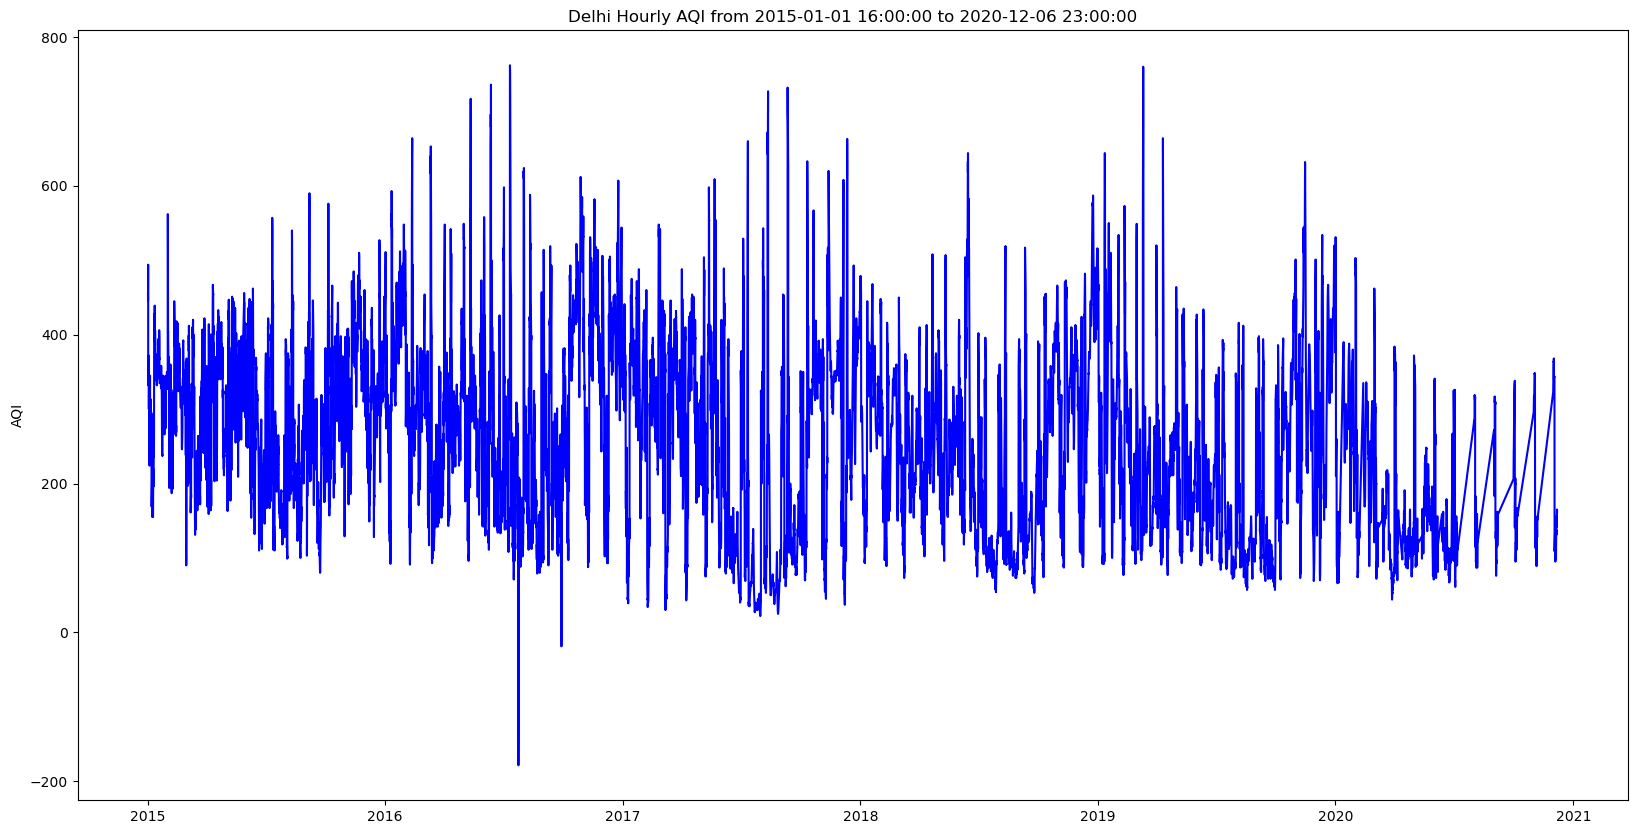

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

df.sort_values('Datetime',inplace=True)
plt.figure(figsize=(20, 10))
plt.plot(df.index,df.AQI,color='b')
#plt.xlabel('Hour')
plt.ylabel('AQI')
plt.title('Delhi Hourly AQI from '+str(df.index[0])+" to "+str(df.index[-1]))

## Running MLP

In [27]:
values = df[df.columns[[0]]].values
# ensure all data is float
values = values.astype('float32')
values

array([[456.],
       [450.],
       [446.],
       ...,
       [165.],
       [165.],
       [162.]], dtype=float32)

In [28]:
#step 2: preprocessing
#B) Scaling
from sklearn.preprocessing import MinMaxScaler

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.6746868 ],
       [0.66830814],
       [0.6640557 ],
       ...,
       [0.36532044],
       [0.36532044],
       [0.3621311 ]], dtype=float32)

In [29]:
from numpy import array,arange

def split_sequence(sequence, lag, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps*lag
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[arange(i,i+(lag*n_steps),lag)], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [30]:
# choose a number of time steps
ED = 3
lag = 1
raw_seq = scaled
#raw_seq = dataset.Rate
# split into samples
X, y = split_sequence(raw_seq, lag, ED)
X,y

(array([[[0.6746868 ],
         [0.66830814],
         [0.6640557 ]],
 
        [[0.66830814],
         [0.6640557 ],
         [0.69488597]],
 
        [[0.6640557 ],
         [0.69488597],
         [0.70020163]],
 
        ...,
 
        [[0.36425734],
         [0.36425734],
         [0.36532044]],
 
        [[0.36425734],
         [0.36532044],
         [0.36532044]],
 
        [[0.36532044],
         [0.36532044],
         [0.36532044]]], dtype=float32),
 array([[0.69488597],
        [0.70020163],
        [0.70445406],
        ...,
        [0.36532044],
        [0.36532044],
        [0.3621311 ]], dtype=float32))

In [32]:
x=df.shape
rows=x[0]
import math
train_rows=math.ceil(rows*0.80)

In [33]:
train_X = X[0:(train_rows-(lag*ED)),:]
train_y = y[0:(train_rows-(lag*ED))]
test_X = X[(train_rows-(lag*ED)):rows,:]
test_y = y[(train_rows-(lag*ED)):rows]

In [34]:
from sklearn.neural_network import MLPRegressor

# reshape 
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))

mlp = MLPRegressor(random_state=0, activation='relu', hidden_layer_sizes=10,max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10)

#mlp = MLPRegressor(random_state=0, activation='tanh', hidden_layer_sizes=(16,8))

mlp.fit(train_X, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.12381032
Iteration 2, loss = 0.01404259
Iteration 3, loss = 0.01170973
Iteration 4, loss = 0.00985967
Iteration 5, loss = 0.00836248
Iteration 6, loss = 0.00712714
Iteration 7, loss = 0.00609529
Iteration 8, loss = 0.00522131
Iteration 9, loss = 0.00447930
Iteration 10, loss = 0.00384502
Iteration 11, loss = 0.00330402
Iteration 12, loss = 0.00284143
Iteration 13, loss = 0.00244719
Iteration 14, loss = 0.00211226
Iteration 15, loss = 0.00182856
Iteration 16, loss = 0.00158955
Iteration 17, loss = 0.00138832
Iteration 18, loss = 0.00122005
Iteration 19, loss = 0.00107956
Iteration 20, loss = 0.00096311
Iteration 21, loss = 0.00086647
Iteration 22, loss = 0.00078650
Iteration 23, loss = 0.00072096
Iteration 24, loss = 0.00066690
Iteration 25, loss = 0.00062258
Iteration 26, loss = 0.00058630
Iteration 27, loss = 0.00055653
Iteration 28, loss = 0.00053229
Iteration 29, loss = 0.00051249
Iteration 30, loss = 0.00049635
Iteration 31, loss = 0.00048315
Training loss did

MLPRegressor(hidden_layer_sizes=10, max_iter=500, random_state=0, solver='sgd',
             verbose=10)

In [35]:
# make predictions on the testing set
y_pred = mlp.predict(test_X)
y_pred

array([0.35424674, 0.35523364, 0.35622054, ..., 0.37255698, 0.37258023,
       0.37312615], dtype=float32)

In [36]:
predictions = scaler.inverse_transform(y_pred.reshape(-1,1))
predictions

array([[154.58372],
       [155.51204],
       [156.44034],
       ...,
       [171.80693],
       [171.8288 ],
       [172.3423 ]], dtype=float32)

In [41]:
actuals = scaler.inverse_transform(test_y.reshape(-1,1))
actuals

array([[148.     ],
       [148.99998],
       [148.     ],
       ...,
       [165.     ],
       [165.     ],
       [162.     ]], dtype=float32)

In [42]:
from sklearn import metrics

# Step 6: Compute the performance of the model using metrics
print("MSE=", metrics.mean_squared_error(actuals, predictions))

MSE= 661.13116


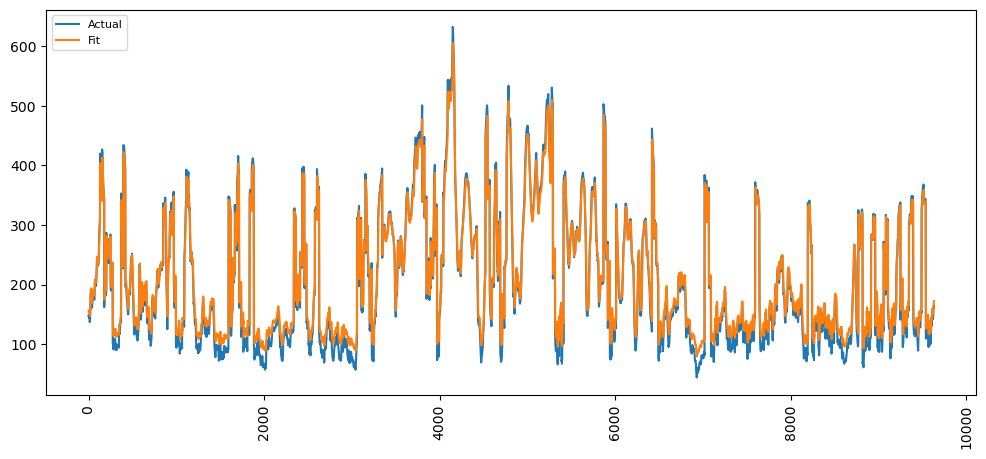

In [43]:
# Plot
%matplotlib inline
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,5))

#actual = df['AQI']

plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Fit')

degrees = 90
plt.xticks(rotation=degrees)
plt.legend(loc='upper left', fontsize=8)

In [44]:
from sklearn import metrics
def calculateRMSE(x,y):
    return (metrics.mean_squared_error(x,y))**0.5

def calculateMAPE(x,y):
    return (100/len(x))*sum(np.abs([(x[i]-y[i])/x[i] for i in range(len(x))]))

In [45]:
rmse_mlp = calculateRMSE(actuals,predictions)
mape_mlp = calculateMAPE(actuals,predictions)

print("The RMSE of the MLP model is ",rmse_mlp)
print("The MAPE of the MLP model is ",mape_mlp)

The RMSE of the MLP model is  25.712470992706656
The MAPE of the MLP model is  [11.52666]
